In [1]:
import tensorflow as tf

import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import numpy as np
import PIL.Image as Image
from keras.preprocessing import image

In [2]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

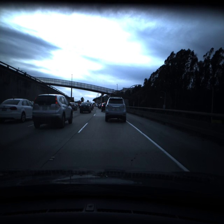

In [3]:
img = Image.open("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/frames/10005.jpg")
img = img.resize((IMAGE_RES,IMAGE_RES))
img

In [4]:
img = np.array(img)/255.0
img.shape

(224, 224, 3)

In [5]:
result = model.predict(img[np.newaxis, ...])
result.shape

(1, 1001)

In [6]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

868

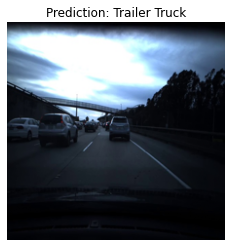

In [7]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [8]:
# Create arrays with filenames and lables
inFile = open("C:/Users/Lukas/Desktop/commaai-speed-challenge/data/train-grouped.txt", "r")
filenames = []
lables = []
for i, v in enumerate(inFile):
	filenames.append(str(i)+".jpg")
	lables.append(v)

filenames = tf.constant(filenames)
labels = tf.constant(lables)
labels

#create Dataset
dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

In [9]:
# load images

def im_file_to_tensor(file, label):
    def _im_file_to_tensor(file, label):
        path = f"C:/Users/Lukas/Desktop/commaai-speed-challenge/data/frames/{file.numpy().decode()}"
        decoded_image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
        decoded_image = tf.image.resize(decoded_image, (IMAGE_RES, IMAGE_RES))/255.0
        im = tf.cast(decoded_image, tf.float32) / 255.0
        #decoded_image funkar, im är svart
        return decoded_image, int(label)
    return tf.py_function(_im_file_to_tensor,
                          inp=(file, label),
                          Tout=(tf.float32, tf.uint8))

dataset = dataset.map(im_file_to_tensor)


In [10]:
#split dataset
train_ds_size = int(0.7 * len(lables))
valid_ds_size = int(0.15 * len(lables))

train_dataset = dataset.take(train_ds_size)
remaining = dataset.skip(train_ds_size)
valid_dataset = remaining.take(valid_ds_size)
test_dataset = remaining.skip(valid_ds_size)

len(train_dataset)

14280

In [11]:
for i, example_image in enumerate(train_dataset.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))  

Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)


In [12]:
BATCH_SIZE = 16

train_batches      = train_dataset.shuffle(len(dataset)//4).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid_dataset.batch(BATCH_SIZE).prefetch(1)

In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['wing', 'trailer truck', 'car mirror', 'volcano', 'car mirror',
       'car mirror', 'car mirror', 'car mirror', 'trailer truck',
       'car mirror', 'wing', 'trailer truck', 'trailer truck',
       'car mirror', 'car mirror', 'car mirror'], dtype='<U30')

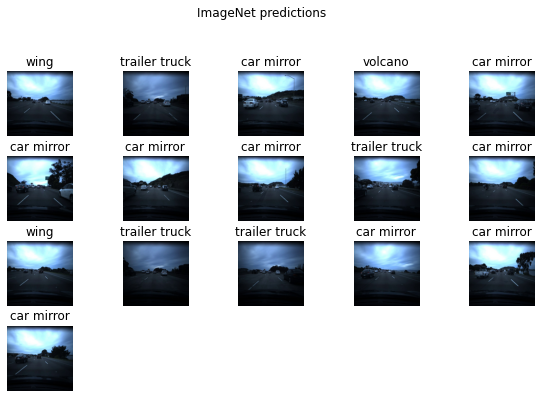

In [14]:
plt.figure(figsize=(10,9))
for n in range(16):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")